In [1]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls")

source("script/packages.R"  )
source("script/input_data.R")
source("script/functions.R" )
source("script/colors.R"    )


In [2]:
dir.create("pipeline/4.14.stage_vs_cell_specific_associations", showWarnings = FALSE)

In [3]:
diftiss = fread("pipeline/4.1.differential_expression/diffexp.txt"     , sep = "\t", header = TRUE, data.table = FALSE)
difcell = fread("pipeline/4.1.differential_expression/diffexp_cell.txt", sep = "\t", header = TRUE, data.table = FALSE)

diftiss = diftiss[diftiss$type != "isoform_tpm",]
difcell = difcell[difcell$type != "isoform_tpm",]

difcell$cell_type = gsub("cibersort.regular.", "", difcell$cell_type)

In [4]:
cells    = unique(difcell$cell_type)
tissues0 = unique(diftiss[,c("tissue1", "tissue2")])


# test cell type proportion differences

In [5]:
covariates           = add_rownames(fread("pipeline/3.1.covariates/covariates.txt"   , sep = "\t", header = TRUE , data.table = FALSE))
covariates$run       = rownames(covariates)
covariates           = covariates[,colnames(covariates) %in% c("run", "ipsc_cvpc", "heart", "arteria") | grepl("cibersort.regular", colnames(covariates)) == TRUE ]
colnames(covariates) = gsub("cibersort.regular.", "", colnames(covariates))


In [6]:

tests_cell_vs_tissue = as.data.frame(rbindlist(lapply(1:nrow(tissues0), function(ii)
{
    tissue1 = tissues0[ii, "tissue1"]
    tissue2 = tissues0[ii, "tissue2"]
    out     = as.data.frame(rbindlist(lapply(cells, function(cell)
    {
        test = t.test(covariates[covariates[,tissue1] == 1, cell], covariates[covariates[,tissue2] == 1, cell])
        out  = data.frame(cell = cell, tissue1 = tissue1, tissue2 = tissue2, estimate1 = test$estimate[[1]], estimate2 = test$estimate[[2]], ci1 = test$conf.int[[1]], ci2 = test$conf.int[[2]], pval = test$p.value)
        
        return(out)
    })), stringsAsFactors = FALSE)
    
    return(out)
})), stringsAsFactors = FALSE)


tests_cell_vs_tissue$log2r = log2(tests_cell_vs_tissue$estimate1 / tests_cell_vs_tissue$estimate2)
tests_cell_vs_tissue$qval  = p.adjust(tests_cell_vs_tissue$pval, method = "BH")

fwrite(tests_cell_vs_tissue, "pipeline/4.14.stage_vs_cell_specific_associations/tests_cell_vs_tissue.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


# Test stage associations with cell type associations

In [17]:
run_fisher_test = function(mycol, indata)
{
    indata$mycol = indata[,mycol]
    out    = data.frame(x11 = nrow(indata[indata$mycol == TRUE  & indata$spec_cell == TRUE , ]),
                        x12 = nrow(indata[indata$mycol == FALSE & indata$spec_cell == TRUE , ]),
                        x21 = nrow(indata[indata$mycol == TRUE  & indata$spec_cell == FALSE, ]),
                        x22 = nrow(indata[indata$mycol == FALSE & indata$spec_cell == FALSE, ])
                       )
    
    totest = matrix(as.numeric(out[1,]), nrow = 2, byrow = TRUE)
    
    test = fisher.test(totest)
    out  = cbind(out, data.frame(estimate = test$estimate, ci1 = test$conf.int[[1]], ci2 = test$conf.int[[2]], pval = test$p.value))
    
    return(out)
}

test_stage_vs_cell = function(cell, tissue1, tissue2, type, diftiss, difcell)
{
    indata = merge(diftiss[ diftiss$tissue1   == tissue1 & diftiss$type == type & diftiss$tissue2 == tissue2, c("transcript_id", "gene_id", "gene_name", "beta", "log2r", "pval", "qval")],
                   difcell[ difcell$cell_type == cell    & difcell$type == type                             , c("transcript_id", "beta", "pval", "qval")],
                   by = "transcript_id", suffixes = c("_stage", "_cell")
                  )
    colnames(indata)[[5]] = "log2r_stage"
    
    indata$spec1_stage = FALSE
    indata$spec2_stage = FALSE
    indata$spec_cell   = FALSE
    
    indata[ indata$qval_stage <= 0.05 & indata$log2r_stage >  2, "spec1_stage"] = TRUE
    indata[ indata$qval_stage <= 0.05 & indata$log2r_stage < -2, "spec2_stage"] = TRUE
    indata[ indata$qval_cell  <= 0.05 & indata$beta_cell   >  0, "spec_cell"  ] = TRUE
    
    test1 = cbind(data.frame(cell = cell, tissue1 = tissue1, tissue2 = tissue2, tissue = tissue1, type = type), run_fisher_test("spec1_stage", indata))
    test2 = cbind(data.frame(cell = cell, tissue1 = tissue1, tissue2 = tissue2, tissue = tissue2, type = type), run_fisher_test("spec2_stage", indata))
    out1  = rbind(test1, test2)
    
    return(out1)
    #indata = indata[is.infinite(indata$log2r_stage) == FALSE,]
    #mycor  = cor.test(indata$log2r_stage, indata$beta_cell)
    mycor  = cor.test(indata$beta_stage, indata$beta_cell)
    
    out2   = data.frame(cell = cell, tissue1 = tissue1, tissue2 = tissue2, type = type, cor = mycor$estimate, pval = mycor$p.value)
    
    return(list(fisher = out1, cor = out2))
}

cell    = "cardiac_muscle"
tissue1 = "ipsc_cvpc"
tissue2 = "heart"
type    = "gene_tpm"

tissues = unique(diftiss[,c("tissue1", "tissue2", "type")])


tests_stage_vs_cell = as.data.frame(rbindlist(lapply(1:nrow(tissues), function(ii)
{
    tissue1 = tissues[ii, "tissue1"]
    tissue2 = tissues[ii, "tissue2"]
    type    = tissues[ii, "type"   ]
    out     = as.data.frame(rbindlist(lapply(cells, function(cell){test_stage_vs_cell(cell, tissue1, tissue2, type, diftiss, difcell)})), stringsAsFactors = FALSE)
    
    return(out)
})), stringsAsFactors = FALSE)

tests_stage_vs_cell$log2r = log2    (tests_stage_vs_cell$estimate)
tests_stage_vs_cell$qval  = p.adjust(tests_stage_vs_cell$pval, method = "BH")
tests_stage_vs_cell       = merge(tests_stage_vs_cell, tests_cell_vs_tissue, by = c("cell", "tissue1", "tissue2"), suffixes = c("_stage", "_tissue"))

tests_stage_vs_cell[tests_stage_vs_cell$tissue == tests_stage_vs_cell$tissue2, "log2r_tissue"] = - tests_stage_vs_cell[tests_stage_vs_cell$tissue == tests_stage_vs_cell$tissue2, "log2r_tissue"]
tests_stage_vs_cell[tests_stage_vs_cell$tissue == tests_stage_vs_cell$tissue2, "ci1_tissue"  ] = - tests_stage_vs_cell[tests_stage_vs_cell$tissue == tests_stage_vs_cell$tissue2, "ci1_tissue"  ]
tests_stage_vs_cell[tests_stage_vs_cell$tissue == tests_stage_vs_cell$tissue2, "ci2_tissue"  ] = - tests_stage_vs_cell[tests_stage_vs_cell$tissue == tests_stage_vs_cell$tissue2, "ci2_tissue"  ]

fwrite(tests_stage_vs_cell, "pipeline/4.14.stage_vs_cell_specific_associations/tests_stage_vs_cell.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


In [23]:
stage2tissue = merge(diftiss, difcell, by = c("transcript_id", "gene_id", "gene_name", "gene_type", "type"), suffixes = c("_stage", "_tissue"))

fwrite(stage2tissue, "pipeline/4.14.stage_vs_cell_specific_associations/stage2tissue.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


In [18]:
str(tests_stage_vs_cell)

'data.frame':	96 obs. of  22 variables:
 $ cell        : chr  "cardiac_muscle" "cardiac_muscle" "cardiac_muscle" "cardiac_muscle" ...
 $ tissue1     : chr  "heart" "heart" "heart" "heart" ...
 $ tissue2     : chr  "arteria" "arteria" "arteria" "arteria" ...
 $ tissue      : chr  "heart" "arteria" "heart" "arteria" ...
 $ type        : chr  "gene_tpm" "gene_tpm" "isoform_use" "isoform_use" ...
 $ x11         : int  525 59 462 1 705 360 511 66 697 503 ...
 $ x12         : int  4417 4883 2531 2992 4237 4582 2482 2927 4245 4439 ...
 $ x21         : int  109 2665 169 318 945 3808 1282 3792 2942 2363 ...
 $ x22         : int  15342 12786 35109 34960 14506 11643 33996 31486 12509 13088 ...
 $ estimate    : num  16.7263 0.058 37.8734 0.0368 2.554 ...
 $ ci1_stage   : num  1.35e+01 4.39e-02 3.15e+01 9.31e-04 2.30 ...
 $ ci2_stage   : num  20.7996 0.0752 45.6902 0.2064 2.8356 ...
 $ pval_stage  : num  2.03e-220 3.35e-259 0.00 3.15e-10 8.12e-67 ...
 $ log2r_stage : num  4.06 -4.11 5.24 -4.77 1.35

In [21]:
cor.test(tests_stage_vs_cell[tests_stage_vs_cell$type == "gene_tpm"   , "log2r_stage"], tests_stage_vs_cell[tests_stage_vs_cell$type == "gene_tpm"   , "log2r_tissue"])
cor.test(tests_stage_vs_cell[tests_stage_vs_cell$type == "isoform_use", "log2r_stage"], tests_stage_vs_cell[tests_stage_vs_cell$type == "isoform_use", "log2r_tissue"])
#cor.test(tests_stage_vs_cell[tests_stage_vs_cell$type == "gene_tpm"    & tests_stage_vs_cell$estimate < , "log2r_stage"], tests_stage_vs_cell[tests_stage_vs_cell$type == "gene_tpm"   , "log2r"])
#cor.test(tests_stage_vs_cell[tests_stage_vs_cell$type == "isoform_use" & , "estimate"], tests_stage_vs_cell[tests_stage_vs_cell$type == "isoform_use", "log2r"])



	Pearson's product-moment correlation

data:  tests_stage_vs_cell[tests_stage_vs_cell$type == "gene_tpm", "log2r_stage"] and tests_stage_vs_cell[tests_stage_vs_cell$type == "gene_tpm", "log2r_tissue"]
t = NaN, df = 46, p-value = NA
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 NaN NaN
sample estimates:
cor 
NaN 



	Pearson's product-moment correlation

data:  tests_stage_vs_cell[tests_stage_vs_cell$type == "isoform_use", "log2r_stage"] and tests_stage_vs_cell[tests_stage_vs_cell$type == "isoform_use", "log2r_tissue"]
t = NaN, df = 46, p-value = NA
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 NaN NaN
sample estimates:
cor 
NaN 


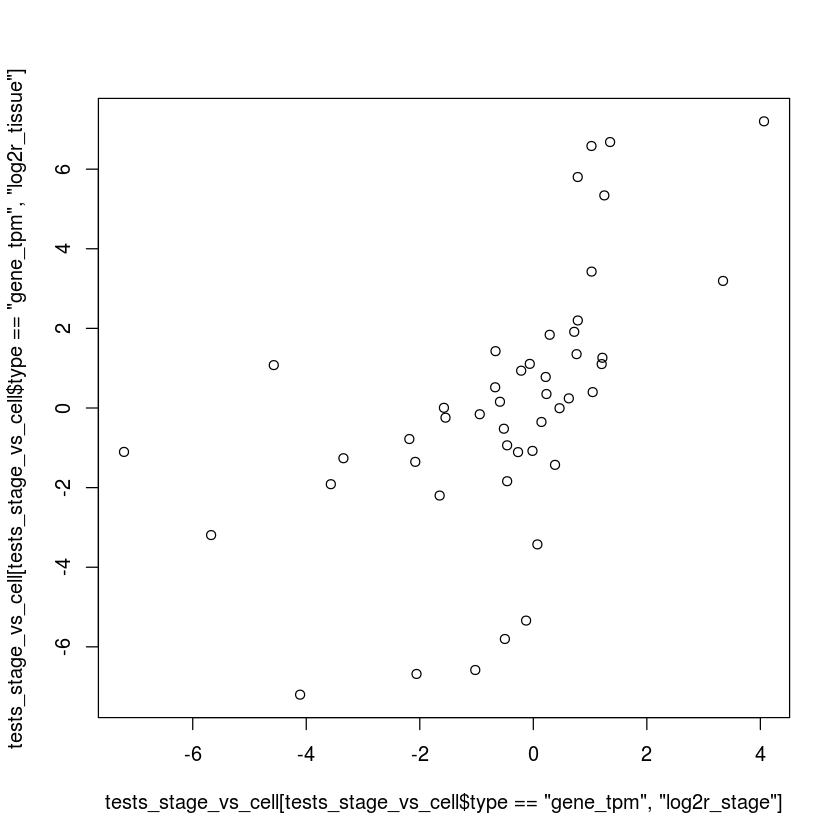

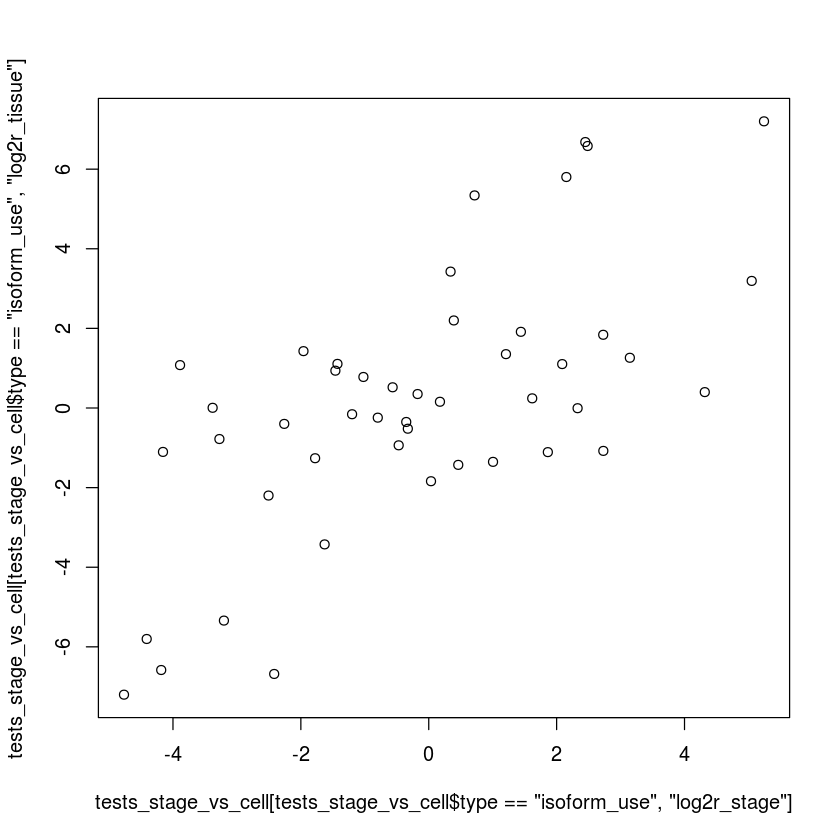

In [22]:
plot(tests_stage_vs_cell[tests_stage_vs_cell$type == "gene_tpm"   , "log2r_stage"], tests_stage_vs_cell[tests_stage_vs_cell$type == "gene_tpm"   , "log2r_tissue"])
plot(tests_stage_vs_cell[tests_stage_vs_cell$type == "isoform_use", "log2r_stage"], tests_stage_vs_cell[tests_stage_vs_cell$type == "isoform_use", "log2r_tissue"])


# look at some examples

In [51]:
look_at_gene = function(gene_name)
{
    this_tiss = diftiss[ diftiss$gene_name == gene_name & diftiss$type == "gene_tpm" & diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "heart", c("log2r", "pval", "qval")]
    this_cell = difcell[ difcell$gene_name == gene_name & difcell$type == "gene_tpm" , c("cell_type", "beta", "pval", "qval")]
    this_test = tests_cell_vs_tissue[ tests_cell_vs_tissue$tissue1 == "ipsc_cvpc" & tests_cell_vs_tissue$tissue2 == "heart", c("cell", "log2r", "pval", "qval")]
    
    return(list(tissue = this_tiss, cell = this_cell, test_cell = this_test))
}
look_at_gene("RBFOX1")
#look_at_gene("RBFOX2")
#look_at_gene("FXR1")



$tissue
         log2r         pval         qval
1272 -1.902267 6.844763e-23 1.395852e-18

$cell
           cell_type       beta         pval         qval
4520  cardiac_muscle  1.5095669 1.634980e-43 2.667371e-38
26359     fibroblast -3.0468092 1.062449e-15 1.733322e-10
28246         immune -2.1707101 8.336384e-15 1.360031e-09
28420    endocardial -2.9573442 9.675514e-15 1.578502e-09
34221    endothelial -2.3637304 1.949320e-12 3.180199e-07
80073 cardiac_neuron -2.7413876 3.188646e-04 1.000000e+00
92103  myofibroblast -1.4027450 3.079750e-03 1.000000e+00
98390  smooth_muscle -0.4233919 7.952647e-03 1.000000e+00

$test_cell
            cell      log2r         pval         qval
1 cardiac_muscle -0.5202659 2.556893e-26 4.383245e-26
2         immune -3.4264156 1.003667e-37 2.007333e-37
3     fibroblast -5.8023938 3.097807e-48 6.758851e-48
4 cardiac_neuron  2.1992497 1.336262e-26 2.466945e-26
5    endocardial  1.1083647 2.343788e-24 3.750062e-24
6    endothelial  0.3508787 2.088990e-03 2.506788e-03
7  smooth_muscle  1.8394090 2.955331e-80 1.418559e-79
8  myofibroblast  0.2425657 2.735294e-01 2.983958e-01

In [49]:
unique(diftiss[ diftiss$gene_name %in% c("RBFOX1", "RBFOX2", "FXR1"), c("gene_name", "gene_id")])

,gene_name,gene_id
,<chr>,<chr>
1272,RBFOX1,ENSG00000078328.21_7
2020,RBFOX2,ENSG00000100320.23_7
3761,FXR1,ENSG00000114416.18_9


In [44]:
library(MASS)

In [45]:
lm.ridge

function (formula, data, subset, na.action, lambda = 0, model = FALSE, 
    x = FALSE, y = FALSE, contrasts = NULL, ...) 
{
    m <- match.call(expand.dots = FALSE)
    m$model <- m$x <- m$y <- m$contrasts <- m$... <- m$lambda <- NULL
    m[[1L]] <- quote(stats::model.frame)
    m <- eval.parent(m)
    Terms <- attr(m, "terms")
    Y <- model.response(m)
    X <- model.matrix(Terms, m, contrasts)
    n <- nrow(X)
    p <- ncol(X)
    offset <- model.offset(m)
    if (!is.null(offset)) 
        Y <- Y - offset
    if (Inter <- attr(Terms, "intercept")) {
        Xm <- colMeans(X[, -Inter])
        Ym <- mean(Y)
        p <- p - 1
        X <- X[, -Inter] - rep(Xm, rep(n, p))
        Y <- Y - Ym
    }
    else Ym <- Xm <- NA
    Xscale <- drop(rep(1/n, n) %*% X^2)^0.5
    X <- X/rep(Xscale, rep(n, p))
    Xs <- svd(X)
    rhs <- t(Xs$u) %*% Y
    d <- Xs$d
    lscoef <- Xs$v %*% (rhs/d)
    lsfit <- X %*% lscoef
    resid <- Y - lsfit
    s2 <- sum(resid^2)/(n - p - Inter)
    HKB <- (p - 2) * s2/sum(lscoef^2)
    LW <- (p - 2) * s2 * n/sum(lsfit^2)
    k <- length(lambda)
    dx <- length(d)
    div <- d^2 + rep(lambda, rep(dx, k))
    a <- drop(d * rhs)/div
    dim(a) <- c(dx, k)
    coef <- Xs$v %*% a
    dimnames(coef) <- list(names(Xscale), format(lambda))
    GCV <- colSums((Y - X %*% coef)^2)/(n - colSums(matrix(d^2/div, 
        dx)))^2
    res <- list(coef = drop(coef), scales = Xscale, Inter = Inter, 
        lambda = lambda, ym = Ym, xm = Xm, GCV = GCV, kHKB = HKB, 
        kLW = LW)
    class(res) <- "ridgelm"
    res
}
<bytecode: 0x87b2140>
<environment: namespace:MASS>